In [1]:
import sys
from ncdmpy.scales import half_mode_mass, alpha_wdm, alpha_beta_gamma_3_to_2_par, dlogT_dlogk
from ncdmpy.ncdmpy import mass_function_beta_mhm, mass_function_dlogTdlogk_mhm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Example 1)
Goal: Get the surpression in the halo mass function and sub-halo mass function of a standard thermal relic with m_x = 3keV. Using the transfer function description from <https://doi.org/10.1093/mnras/stt829"> (Schneider et al. 2013).

The transfer function 
$$
T(k) = \sqrt{P_{WDM}(k)/P_{CDM}(k)}  =  (1 + (\alpha k)^{2 \mu})^{-5 / \mu}
$$
with $\mu=1.12$ corresponds to $\alpha=\alpha$, $\beta=2.24$, $\gamma = 4.464$ in our description
$$
T(k) = (1 + (\alpha k)^{\beta})^{-\gamma}
$$
We first to have to approximate it through a function with a new $\beta^*$ and with $\gamma^*=5$

In [2]:
alpha = alpha_wdm(omega_x=0.27, h=0.7, mx=3.) 
beta, gamma = 1.245, 5./1.12
alphanew, betanew, gammanew = alpha_beta_gamma_3_to_2_par(alpha, beta, gamma, gammamap=5.)
print("alpha = %.5f, beta = %.3f, gamma = %.1f" % (alpha, beta, gamma))
print("alphanew = %.5f, betanew = %.3f, gammanew = %.1f" % (alphanew, betanew, gammanew))
print('dlogT_dlogk: ', dlogT_dlogk(betanew,gammanew))

alpha = 0.01460, beta = 1.245, gamma = 4.5
alphanew = 0.01302, betanew = 1.234, gammanew = 5.0
dlogT_dlogk:  0.7985449480872617


In [3]:
# calculate the half mode mass
mhm = half_mode_mass(alphanew, betanew, gammanew)
print("mhm = %.2e Msol/h" % mhm)

mhm = 2.54e+09 Msol/h


/Users/danielgilman/Code/external/ncdmpy/ncdmpy/ncdmpy.py:28: UserWarning: beta = 1.23 is outside the validated range [1.5 ... 6]! Usage at your own risk!
  warnings.warn("beta = %.2f is outside the validated range [1.5 ... 6]!"


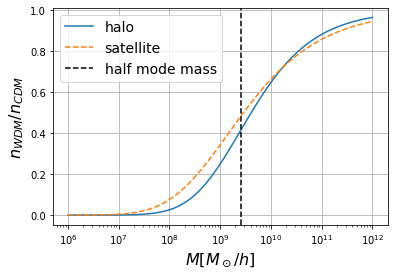

In [4]:
# Now get the mass function
m = np.logspace(6,12)

fhalo = mass_function_beta_mhm(m, beta=betanew, mhm=mhm, mode="halo")
fsat = mass_function_beta_mhm(m, beta=betanew, mhm=mhm, mode="satellite")

plt.semilogx(m, fhalo, label="halo")
plt.semilogx(m, fsat, label="satellite", linestyle="dashed")
plt.axvline(mhm, label="half mode mass", color="black", linestyle="dashed")
plt.legend(fontsize=14)
plt.grid()
plt.xlabel(r"$M [M_\odot /h]$", fontsize=16)
plt.ylabel(r"$n_{WDM} / n_{CDM}$", fontsize=16);

# Compare different thermal relic masses

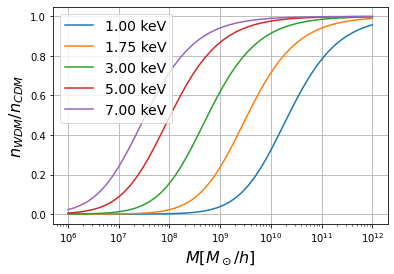

In [5]:
for mx in 1.,1.75,3.,5.,7:
    alpha = alpha_wdm(omega_x=0.27, h=0.7, mx=mx)
    alphanew, betanew, gammanew = alpha_beta_gamma_3_to_2_par(alpha, 2.24, 5./1.12, gammamap=5.)
    mhm = half_mode_mass(alphanew, betanew, gammanew)
    
    fhalo = mass_function_beta_mhm(m, beta=betanew, mhm=mhm, mode="halo")
    
    plt.semilogx(m, fhalo, label="%.2f keV" % mx)
    plt.legend(fontsize=14, loc="upper left")
    plt.grid()
    plt.xlabel(r"$M [M_\odot /h]$", fontsize=16)
    plt.ylabel(r"$n_{WDM} / n_{CDM}$", fontsize=16)

In [6]:
def mass_function_turnover(m, log_mc, a_mfunc_break, b_mfunc_break, c_mfunc_break):
    
    m_c = 10 ** log_mc
    r = a_mfunc_break * (m_c / m) ** b_mfunc_break
    factor = 1 + r
    return factor ** c_mfunc_break

def concentration_function_turnover(m, log_mc, a, b):
    
    mhm = 10 ** log_mc
    log10u = np.log10(m / mhm)
    argument = (log10u - a) / (2 * b)
    return 0.5 * (1 + np.tanh(argument))

def concentration_function_turnover_bose(m, log_mc, a, b, c):
    
    mhm = 10 ** log_mc
    return (1 + a * (mhm / m) ** b) ** c

def a_func_mfunc(x, norm=0.33, slope=-0.072):
    y = norm + slope * (x - 0.5)
    return y

def b_func_mfunc(x, norm=0.28, slope=0.6):
    y = norm + slope * (x - 0.5)
    return y

def a_func_mcrel(x, norm=0.75, slope=0.4):
    y = norm * (0.7 / (x)) ** slope
    return y

def b_func_mcrel(x, norm=0.94, slope=0.7, shift=0.6):
    y = norm * abs(np.log(1.76 + shift) / np.log(x + shift)) ** slope
    return y

def mfunc_params_from_x(x):
    # domain ~ 0.8 - 3.0
    a_wdm = a_func_mfunc(x)
    b_wdm = b_func_mfunc(x)
    c_wdm = -3.0
    kwargs_model = {'a_mfunc_break': a_wdm, 'b_mfunc_break': b_wdm, 'c_mfunc_break': c_wdm}
    return kwargs_model

def mcrelation_params_from_x(x):
    # domain ~ 0.8 - 3.0
    a_wdm = a_func_mcrel(x)
    b_wdm = b_func_mcrel(x)
    kwargs_model = {'a': a_wdm, 'b': b_wdm}
    return kwargs_model

def plot(m, log_mc, kwargs_model, suppression_function, kwargs_plot):
    
    wdm = suppression_function(m, log_mc, **kwargs_model)
    plt.loglog(m/10**log_mc, wdm, **kwargs_plot)
    

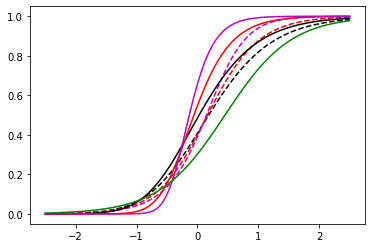

In [7]:
m_units_mhm = np.logspace(-2.5, 2.5, 100)
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 1.3)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='k', linestyle='--')
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 2.0)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='r', linestyle='--')
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 3.0)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='m', linestyle='--')

x = 1.3
kwargs_wdm_mfunc_x = mfunc_params_from_x(x)
dndm_suppression_x = mass_function_turnover(m_units_mhm, 0.0, **kwargs_wdm_mfunc_x)
plt.plot(np.log10(m_units_mhm), dndm_suppression_x, color='k')
x = 2.0
kwargs_wdm_mfunc_x = mfunc_params_from_x(x)
dndm_suppression_x = mass_function_turnover(m_units_mhm, 0.0, **kwargs_wdm_mfunc_x)
plt.plot(np.log10(m_units_mhm), dndm_suppression_x, color='r')
x = 3.0
kwargs_wdm_mfunc_x = mfunc_params_from_x(x)
dndm_suppression_x = mass_function_turnover(m_units_mhm, 0.0, **kwargs_wdm_mfunc_x)
plt.plot(np.log10(m_units_mhm), dndm_suppression_x, color='m')

a_wdm = 2.3
b_wdm = 0.8
c_wdm = -1.0
kwargs_lovell_2020 = {'a_mfunc_break': a_wdm, 'b_mfunc_break': b_wdm, 'c_mfunc_break': c_wdm}
dndm_suppression_lovell = mass_function_turnover(m_units_mhm, 0.0, **kwargs_lovell_2020)
plt.plot(np.log10(m_units_mhm), dndm_suppression_lovell, color='g')

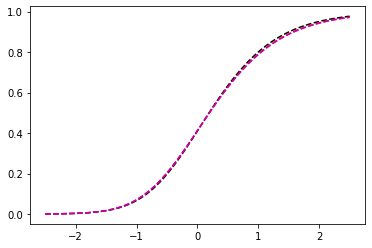

In [15]:
m_units_mhm = np.logspace(-2.5, 2.5, 100)
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 1.0, gamma=2.)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='k', linestyle='--')
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 1.0, gamma=5.0)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='r', linestyle='--')
dndm_suppression = mass_function_dlogTdlogk_mhm(m_units_mhm, 1.0, gamma=8.0)
plt.plot(np.log10(m_units_mhm), dndm_suppression, color='m', linestyle='--')
